**Function 2**

Optimising Noisy Models. This corresponds to trying to optimise an unknown machine learning model. However, the initialization of the model is very important, meaning your observations will be very noisy, and the problem might **have a lot of local optima! You are trying to make the model’s log-likelihood as large as possible.**

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f2_inputs = np.load("initial_inputs1.npy")
f2_outputs = np.load("initial_outputs1.npy")
f2_inputs_2 = np.load("initial_inputs2.npy")
f2_outputs_2 = np.load("initial_outputs2.npy")

In [3]:
f2_inputs = np.concatenate((f2_inputs, f2_inputs_2)) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.773955, 0.818842]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.516179, 0.852595]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.682636, 0.906564]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.657373, 0.92707 ]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.738282, 0.94505 ]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.695969, 0.942119]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.695969, 0.942119]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.722636, 0.906564]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.650546, 0.929693]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.742636, 0.904341]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.702733, 0.458018]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.717983, 0.664498]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.704501, 0.451105]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.705161, 0.457239]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.702733, 0.418018]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.742733, 0.435796]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.702733, 0.458018]]))) 
f2_inputs = np.concatenate((f2_inputs, np.array([[0.720511, 0.458018]]))) 

f2_outputs = np.concatenate((f2_outputs,f2_outputs_2)) 
f2_outputs = np.append(f2_outputs,0.26215841751744595)
f2_outputs = np.append(f2_outputs,0.30798911881434576)
f2_outputs = np.append(f2_outputs,0.5004746350462992)
f2_outputs = np.append(f2_outputs,0.4295013179054613)
f2_outputs = np.append(f2_outputs,0.41771047535557376)
f2_outputs = np.append(f2_outputs,0.4720670123276774)
f2_outputs = np.append(f2_outputs,0.5825927664580692)
f2_outputs = np.append(f2_outputs,0.6659374421056163)
f2_outputs = np.append(f2_outputs,0.33114062352865725)
f2_outputs = np.append(f2_outputs,0.43942137201542275)
f2_outputs = np.append(f2_outputs,0.6400642111494899)
f2_outputs = np.append(f2_outputs,0.2962440276848424)
f2_outputs = np.append(f2_outputs,0.6921593595462521)
f2_outputs = np.append(f2_outputs,0.6363815236340811)
f2_outputs = np.append(f2_outputs,0.481611594015654)
f2_outputs = np.append(f2_outputs,0.4107324217400383)
f2_outputs = np.append(f2_outputs,0.6640016362646336)
f2_outputs = np.append(f2_outputs,0.5446540910696784)


In [4]:
X_max= f2_inputs[np.argmax((f2_outputs))]
print(X_max)

[0.7227338  0.43801822]


In [5]:
Y_max= f2_outputs[np.argmax((f2_outputs))]
print(Y_max)

0.6948320857901906


In [30]:
def costly_function(x):
    total = np.array([])
    for x_i in x:
         total = np.append(total, np.sum(np.exp(-(x_i - 5) ** 2)))
        #total =  -x_i ** 2 - (x_i - 1) ** 2 + 1
    
    return total  + np.random.randn()  

In [31]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.scale = scale
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []
        
    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for 
        # a new trial data point to avoid cost 
 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for 
        # entire prior distribution to avoid cost
        
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y-5) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp
    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
    
    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
            
            # Trial with an array of random data points
            
            #for x_start in (np.random.random((self.batch_size,self.x_init.shape[1])) * self.scale):
            for x_start in np.random.uniform(low=0.1, high=0.99, size=(1,2)):
                response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
                if response.fun < min_ei:
                    min_ei = response.fun
                    x_optimal = response.x
            
            return x_optimal, min_ei
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array(y), axis = 0)
        
    def optimize(self):
        y_max_ind = np.argmax(self.y_init)
        y_max = self.y_init[y_max_ind]
        optimal_x = self.x_init[y_max_ind]
        optimal_ei = None
        for i in range(self.n_iter):
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array([x_next]))
            self._extend_prior_with_posterior_data(x_next,y_next)
            
            if y_next[0] > y_max:
                y_max = y_next[0]
                optimal_x = x_next
                optimal_ei = ei

            if i == 0:
                 prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
            tmpdf = pd.DataFrame({"y": y_max, "ei": optimal_ei},index=[1])
            #self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei},ignore_index=True)
            self.best_samples_ =pd.concat([self.best_samples_ ,tmpdf],ignore_index = True)
        
        return optimal_x, y_max
  
  
        

In [17]:
sample_x = f2_inputs
sample_y = f2_outputs

In [34]:
bopt = BayesianOptimizer(target_func=costly_function, x_init=sample_x, y_init=sample_y, n_iter=200, scale=10, batch_size=30)
bopt.optimize()

(array([0.275328  , 0.89068836]), 2.9134261775216)

In [30]:
#(array([4.03553488, 6.13089465]), 3.45292516709551)

In [32]:
f2_inputs

array([[0.66579958, 0.12396913],
       [0.87779099, 0.7786275 ],
       [0.14269907, 0.34900513],
       [0.84527543, 0.71112027],
       [0.45464714, 0.29045518],
       [0.57771284, 0.77197318],
       [0.43816606, 0.68501826],
       [0.34174959, 0.02869772],
       [0.33864816, 0.21386725],
       [0.70263656, 0.9265642 ],
       [0.33162594, 0.08049911],
       [0.10053279, 0.47759524],
       [0.67793216, 0.87370355],
       [0.13495584, 0.52115767],
       [0.53715567, 0.24471459],
       [0.6591284 , 0.63064156],
       [0.47045207, 0.53376825],
       [0.72120239, 0.36450644],
       [0.7227338 , 0.43801822],
       [0.24066761, 0.14122907],
       [0.773955  , 0.818842  ],
       [0.516179  , 0.852595  ],
       [0.682636  , 0.906564  ],
       [0.657373  , 0.92707   ],
       [0.738282  , 0.94505   ],
       [0.695969  , 0.942119  ],
       [0.695969  , 0.942119  ],
       [0.722636  , 0.906564  ],
       [0.650546  , 0.929693  ],
       [0.742636  , 0.904341  ],
       [0.

In [33]:
f2_outputs

array([ 0.53899612,  0.42058624, -0.06562362,  0.29399291,  0.21496451,
        0.02310555,  0.24461934,  0.03874902, -0.01385762,  0.61120522,
       -0.02995427,  0.08311962,  0.56114332,  0.01347696,  0.38994406,
        0.42201818,  0.58695686,  0.56954976,  0.69483209,  0.03376806,
        0.26215842,  0.30798912,  0.50047464,  0.42950132,  0.41771048,
        0.47206701,  0.58259277,  0.66593744,  0.33114062,  0.43942137,
        0.64006421,  0.29624403,  0.69215936,  0.63638152])

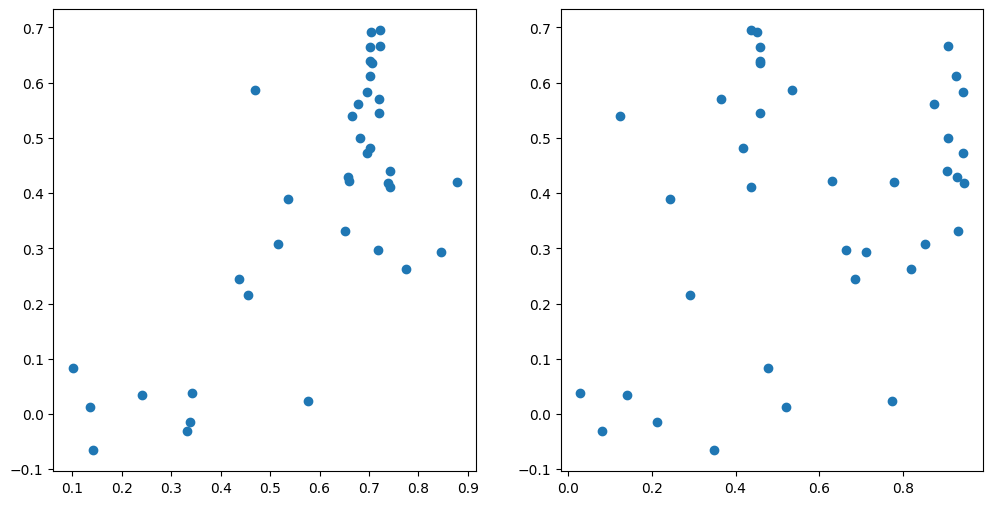

In [6]:
fig, ax = plt.subplots(1,2,figsize = (12,6))
ax[0].scatter(f2_inputs[:,0],f2_outputs)
ax[1].scatter(f2_inputs[:,1],f2_outputs)
plt.show()